# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [306]:
import torch
torch.cuda.is_available()

False

In [2]:

from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-24 15:07:22--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [              <=>   ] 201.24M  13.1MB/s    in 27s     

2024-10-24 15:07:50 (7.36 MB/s) - ‘data.txt.zip’ saved [211011981]



In [4]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [5]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]


## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [7]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [8]:
set_random_seed(42)

In [9]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [10]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
model = Ridge(random_state=42).fit(X_train_scaled,y_train)
y_pred = model.predict(X_test_scaled)
rmse_for_model = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE = {rmse_for_model}')

RMSE = 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [11]:
best_constant = np.mean(y_test)
y_pred_constant = np.full(y_test.shape, best_constant) #создадим array для константного прогноза

best_rmse_metric = np.sqrt(mean_squared_error(y_test, y_pred_constant))
print(f'Лучший RMSE для константного прогноза: {best_rmse_metric}')

Лучший RMSE для константного прогноза: 10.851909820717683


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [12]:
# ⸂⸂⸜(രᴗര๑)⸝⸃⸃ Good luck!
# Для начала обрежем наш датасет, чтобы нам хватило памяти обучить модельку

X_train_sh = X_train_scaled[:10000, :] # Для этого возьмем для трейна возьмем только первые 10000 наблюдений
y_train_sh = y_train[:10000]
X_test_sh = X_test_scaled[:1000, :] # Дляя теста 1000
y_test_sh = y_test[:1000]

X_train_tensor = torch.tensor(X_train_sh,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sh,dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_sh,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_sh,dtype=torch.float32)


In [13]:

set_random_seed(42)

# Создадим нашу модельку, которая будет состоять только из одного слоя:
class axe(nn.Module):
    def __init__(self, input_size, output_size):
        super(axe, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return self.linear(x)

# Функция потерь (MSE)
def mse(y_true, y_pred):
    return (torch.mean((y_true - y_pred) ** 2))

model = axe(90,1)



Epoch [1/10], RMSE Train Loss: 1998.9448466628587, RMSE Test Loss: 1672.8350934865039
Epoch [2/10], RMSE Train Loss: 1671.1381600573905, RMSE Test Loss: 1405.321715835915
Epoch [3/10], RMSE Train Loss: 1402.3283763084878, RMSE Test Loss: 1184.6793870073034
Epoch [4/10], RMSE Train Loss: 1178.7230378676747, RMSE Test Loss: 997.4211434995751
Epoch [5/10], RMSE Train Loss: 991.9121684907388, RMSE Test Loss: 842.0563743004384
Epoch [6/10], RMSE Train Loss: 835.5106597165592, RMSE Test Loss: 710.3171166809934
Epoch [7/10], RMSE Train Loss: 704.3889195607778, RMSE Test Loss: 600.419905149721
Epoch [8/10], RMSE Train Loss: 594.3494605448885, RMSE Test Loss: 507.3403843821227
Epoch [9/10], RMSE Train Loss: 501.929449101166, RMSE Test Loss: 429.397433911755
Epoch [10/10], RMSE Train Loss: 424.25928098275, RMSE Test Loss: 363.44282562736055


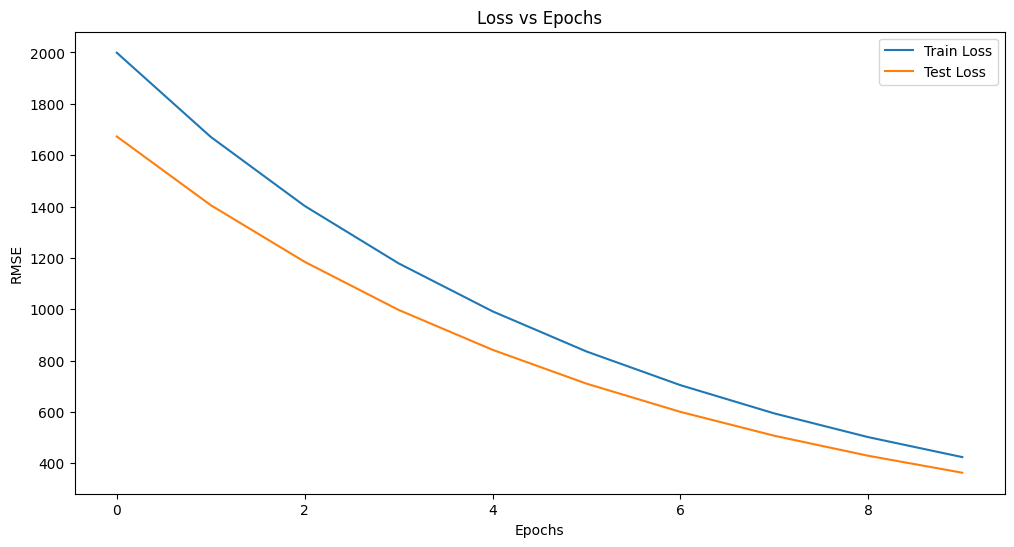

In [14]:
set_random_seed(42)

#Введем наши параметры
learning_rate = 0.08
epochs = 10
train_losses = []
test_losses = []

#Запустим наш цикл

for epoch in range(epochs):
  model.train()
  pred = model(X_train_tensor)
  loss_train = mse(y_train_tensor,pred)
  train_losses.append((loss_train.item())**0.5)
  loss_train.backward()

  with torch.no_grad():
    for params in model.parameters():
      if params.grad is not None:
        params.data -= learning_rate * params.grad.data

  for param in model.parameters():
    param.grad = None

  model.eval()
  pred = model(X_test_tensor)
  loss_test = mse(y_test_tensor,pred)
  test_losses.append((loss_test.item())**0.5)

  print(f'Epoch [{epoch + 1}/{epochs}], RMSE Train Loss: {(loss_train.item())**0.5}, RMSE Test Loss: {(loss_test.item())**0.5}')





# Визуализация потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()


## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [312]:
y_train_scaled = scaler.fit_transform(y_train.reshape(-1,1)) # отскейли игрик
y_test_scaled = scaler.transform(y_test.reshape(-1,1))

# нам нужно работать с тензорами
X_train_tensor = torch.tensor(X_train_scaled,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled,dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled,dtype=torch.float32)



In [313]:
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
set_random_seed(42)


#Создадим нейронку из 4 слоев
class Invoker(nn.Module):
    def __init__(self, n_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(n_features, n_features // 2),
            nn.ReLU(),
            nn.Linear(n_features // 2, n_features // 4),
            nn.ReLU(),
            nn.Linear(n_features // 4, n_features // 8),
            nn.ReLU(),
            nn.Linear(n_features // 8, 1)
        )
    def forward(self, X):
      return self.model(X)


train_set = TensorDataset(X_train_tensor,y_train_tensor)
train_loader = DataLoader(train_set, shuffle=True, batch_size=1500)
test_set = TensorDataset(X_test_tensor,y_test_tensor)
test_loader = DataLoader(test_set, shuffle=True, batch_size= 3000)



n_features = 90
lr = 0.01




model = Invoker(n_features)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.MSELoss()


In [314]:
def train(model, optimizer, criterion, train_loader, test_loader):
    num_epochs = 6
    train_losses = []
    test_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
# пробегаем по бачам трейна
        for inputs, targets in tqdm(train_loader,desc='Training'):
            inputs = inputs.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
# назад отскейливаем, чтобы посчитать лосс
            loss_inv = criterion(torch.tensor(scaler.inverse_transform(outputs.detach())), torch.tensor(scaler.inverse_transform(targets.detach())))
            loss.backward()
            optimizer.step()
            train_loss += loss_inv.item() * len(inputs)


        train_loss /= len((train_loader.dataset))
        train_losses.append(((train_loss))**0.5)
        # scheduler.step()


# Тестирование на тестовом наборе
        model.eval()
        test_loss = 0.0


        for inputs, targets in test_loader:
          inputs = inputs.to(device)
          targets = targets.to(device)
          with torch.no_grad():

                outputs = model(inputs)

                loss = criterion(torch.tensor(scaler.inverse_transform(outputs)), torch.tensor(scaler.inverse_transform(targets)))

                test_loss += loss.item() * len(inputs)

        test_loss /= len((test_loader.dataset))
        test_losses.append((test_loss)**0.5)

        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}')

    return train_losses, test_losses


    raise NotImplementedError


def test(model, criterion, test_loader):
    model.eval()  # Устанавливаем модель в режим оценки
    all_predictions = []

    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Обратное масштабирование
            outputs_inv = scaler.inverse_transform(outputs.cpu().numpy())
            all_predictions.append(torch.tensor(outputs_inv))

    # Конкатенируем все предсказания в один тензор
    predicts = torch.cat(all_predictions)

    return predicts
    # predicts = torch.ones(len(test_loader.dataset))


In [310]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

Training:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [1/6], Train Loss: 8.9864, Test Loss: 8.9074


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [2/6], Train Loss: 8.7541, Test Loss: 8.8619


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [3/6], Train Loss: 8.6845, Test Loss: 8.8387


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [4/6], Train Loss: 8.6477, Test Loss: 8.8323


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [5/6], Train Loss: 8.6093, Test Loss: 8.8035


Training:   0%|          | 0/310 [00:00<?, ?it/s]

Epoch [6/6], Train Loss: 8.5888, Test Loss: 8.7831


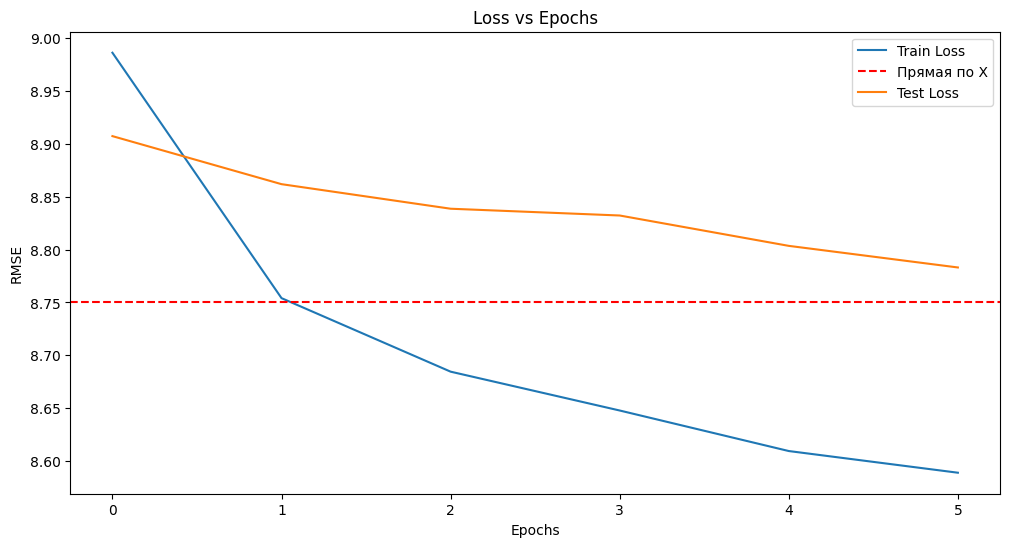

In [315]:
# ೭੧(❛〜❛✿)੭೨ Go forward!
set_random_seed(42)

train_losses, test_losses = train(model, optimizer, criterion, train_loader, test_loader)




# # Визуализация потерь
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Train Loss')
plt.axhline(y=8.75, color='r', linestyle='--', label='Прямая по X')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Сколько же времени было потрачено на этот номер, не описать словами. Все началось с построения обычной нейронки из двух слоев, и без скейла y, я долго менял все параметры: и lr и бачи и даже добавлял декей, но все не опускалось ниже 10.7, затем я решил отскейлить игрик как и просят в задании, а также сделать нейронку из 4 слоев, и моя ошибка сразу упала до 9 и меньше. Далее я менял lr и батч сайз, но все упиралось в 8.85-8.9. Также одной из главной пробелм стало переобучение модели, а именно как только ошибка на трейне достигала 8.57, то модель начала резко переобучаться и тест начал улетать вверх.Так что принято было как то с этим боротться и добавить вейт декей, но достигнуть желанного 8.75 так и не удавалос, поэтому я решил даже воспользоваться cosine scheduler, который отпимизрует шаг обучения, но к сожалению даже это мне не помогло выбить меньше 8.75, максимальный мой результат остановился на ометке с 8.7831:((((((((((((((((


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

In [ ]:
model = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [ ]:
def test_classification(model, criterion, test_loader):

    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    predicts = torch.ones(len(test_loader.dataset))
    return predicts

In [ ]:
assert test_classification(model, criterion, test_loader).shape[0] == y_test.shape[0]

In [ ]:
# ೭੧(❛〜❛✿)੭೨ Go forward!